In [53]:
# extract_feature.py

import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

def load_data(file_pattern):
    """
    Load and process CSV files matching the given file pattern, one at a time.
    """
    all_files = glob.glob(file_pattern)
    processed_data = []

    for filename in all_files:
        print("Processing file: ", filename)
        df = pd.read_csv(filename, index_col=None, header=0)
        X_processed, y_processed = preprocess_data(df)
        if X_processed.size > 0:  # Check if there's data to add
            processed_data.append((X_processed, y_processed))

    # Combine data from all files
    X_combined = np.concatenate([data[0] for data in processed_data], axis=0) if processed_data else np.array([])
    y_combined = np.concatenate([data[1] for data in processed_data], axis=0) if processed_data else np.array([])

    return X_combined, y_combined


def euclidean_distance(lat1, lon1, lat2, lon2):
    return ((lat2 - lat1)**2 + (lon2 - lon1)**2)**0.5

def preprocess_data(frame):
    """
    Perform data preprocessing: feature extraction, scaling, and reshaping into trajectories.
    """
    frame['day'] = pd.to_datetime(frame['time']).dt.day
    frame['month'] = pd.to_datetime(frame['time']).dt.month
    frame['year'] = pd.to_datetime(frame['time']).dt.year
    frame["time"] = pd.to_datetime(frame["time"])
    # frame["time_in_seconds"] = frame["time"].dt.hour * 3600 + frame["time"].dt.minute * 60 + frame["time"].dt.second
    frame["time_in_hour"] = frame["time"].dt.hour
    frame["time_in_minute"] = frame["time"].dt.minute
    frame["time_in_seconds"] = frame["time"].dt.second
    frame['plate'] = frame['plate'].astype('int64')
    
    
    frame['displacement'] = euclidean_distance(frame['latitude'], frame['longitude'],
                                     frame.shift(1)['latitude'], frame.shift(1)['longitude']).fillna(0)

    frame['speed'] = frame['displacement'] / (frame['time_in_seconds'].diff())

    frame['speed'] = frame['speed'].replace([np.inf, -np.inf], 0)

    frame['speed'] = frame['speed'].fillna(0)
    
    frame['acceleration'] = frame['speed'].diff() / (frame['time_in_seconds'].diff())


    frame['acceleration'] = frame['acceleration'].replace([np.inf, -np.inf], 0)

    frame['acceleration'] = frame['acceleration'].fillna(0)

    # X = frame[['longitude', 'latitude', 'status', 'day', 'month', 'time_in_seconds']].values
    X = frame[['longitude', 'latitude', 'status', 'day', 'month', 'time_in_hour', 'time_in_minute', 'time_in_seconds', \
               'displacement', 'speed', 'acceleration']].values
    Y = frame['plate']

    scaler = StandardScaler()
    
    X_reshaped = []
    y_reshaped = []

    # Process each unique plate separately
    for plate in frame['plate'].unique():
        plate_frame = frame[frame['plate'] == plate]

        # Extract the features for the current plate
        # X_plate = plate_frame[['longitude', 'latitude', 'status', 'day', 'month', 'time_in_seconds']].values
        X_plate = plate_frame[['longitude', 'latitude', 'status', 'day', 'month', 'time_in_hour', 'time_in_minute', 'time_in_seconds', \
                              'displacement', 'speed', 'acceleration']].values

        # Check if there is data to process
        if len(X_plate) > 0:
            X_scaled = scaler.fit_transform(X_plate)

            # Segment data into 100-step chunks, padding the last chunk if necessary
            num_chunks = len(X_scaled) // 100
            for i in range(num_chunks):
                chunk = X_scaled[i*100:(i+1)*100]
                X_reshaped.append(chunk)
                y_reshaped.append(plate)  # Appending the plate number for each chunk

            # Padding the last chunk if it's smaller than 100
            if len(X_scaled) % 100 != 0:
                last_chunk = X_scaled[num_chunks*100:]
                last_chunk_padded = np.pad(last_chunk, ((0, 100 - len(last_chunk)), (0, 0)), mode='constant')
                X_reshaped.append(last_chunk_padded)
                y_reshaped.append(plate)  # Appending the plate number for the padded chunk

    # Convert to numpy arrays
    X_reshaped = np.array(X_reshaped)
    y_reshaped = np.array(y_reshaped)
    # print(X_reshaped.shape, y_reshaped.shape)

    return X_reshaped, y_reshaped

In [2]:
# model.py

import torch.nn as nn

class TaxiDriverClassifier(nn.Module):
    """
    Input:
        Data: the output of process_data function.
        Model: your model.
    Output:
        prediction: the predicted label(plate) of the data, an int value.
    """
    def __init__(self, input_dim, output_dim):
        super(TaxiDriverClassifier, self).__init__()

        ###########################
        # YOUR IMPLEMENTATION HERE #
        self.input_layer = nn.LSTM(input_dim, 64, batch_first=True)
        self.hidden1 = nn.LSTM(64, 64, batch_first=True)
        self.hidden2 = nn.LSTM(64, 64, batch_first=True)
        self.output = nn.Linear(64, output_dim)
        ###########################

    def forward(self, x):
        # x.size(0) = batch size; x.size(1) = seq size
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        ###########################
        
        h_t1 = torch.zeros(1, x.size(0), self.input_layer.hidden_size).to(x.device)
        c_t1 = torch.zeros(1, x.size(0), self.input_layer.hidden_size).to(x.device)

        h_t2 = torch.zeros(1, x.size(0), self.hidden1.hidden_size).to(x.device)
        c_t2 = torch.zeros(1, x.size(0), self.hidden1.hidden_size).to(x.device)

        h_t3 = torch.zeros(1, x.size(0), self.hidden2.hidden_size).to(x.device)
        c_t3 = torch.zeros(1, x.size(0), self.hidden2.hidden_size).to(x.device)

        # Forward through the LSTM layers
        # x tensor (128, 100, 64) h tensor (1, 128, 64)        
        h_t1, c_t1 = self.input_layer(x, (h_t1, c_t1))
        h_t2, c_t2 = self.hidden1(h_t1, (h_t2, c_t2))
        h_t3, c_t3 = self.hidden2(h_t2, (h_t3, c_t3))

        # Output layer
        x = self.output(h_t3) # (batch size, sequential length, output dim)
        
        ###########################
        return x[:,-1,:]
    

In [3]:
# Define the dimensions
input_size = 8  # p is the dimension of the feature space
output_size = 5   # Output size of the model, adjust as needed

# Instantiate the model
model = TaxiDriverClassifier(input_size, output_size)

# Print the model architecture
print(model)
print(list(model.input_layer.parameters()))

TaxiDriverClassifier(
  (input_layer): LSTM(8, 64, batch_first=True)
  (hidden1): LSTM(64, 64, batch_first=True)
  (hidden2): LSTM(64, 64, batch_first=True)
  (output): Linear(in_features=64, out_features=5, bias=True)
)
[Parameter containing:
tensor([[-0.0086,  0.0626, -0.0682,  ..., -0.0756,  0.0429,  0.0761],
        [-0.0090,  0.1182,  0.1215,  ..., -0.0314,  0.0945,  0.1081],
        [-0.0085, -0.0982,  0.0622,  ..., -0.0013, -0.1191, -0.0242],
        ...,
        [ 0.0953, -0.0561, -0.0174,  ...,  0.0925,  0.0081,  0.0060],
        [-0.0758, -0.1038, -0.0253,  ..., -0.0839,  0.0974, -0.0062],
        [ 0.0819, -0.0244, -0.0683,  ..., -0.0596, -0.0215, -0.1130]],
       requires_grad=True), Parameter containing:
tensor([[ 0.0189,  0.0908, -0.0414,  ..., -0.0892,  0.0146,  0.0107],
        [-0.1101, -0.0190,  0.0209,  ..., -0.0447, -0.0723, -0.0708],
        [-0.0090,  0.0313, -0.0743,  ...,  0.0560,  0.0110, -0.0638],
        ...,
        [ 0.0059,  0.0322, -0.0079,  ..., -0.0759

In [70]:
# train.py

import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
#from model import TaxiDriverClassifier
from extract_feature import load_data, preprocess_data

from sklearn.model_selection import train_test_split

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

class TaxiDriverDataset(Dataset):
    """
    Custom dataset class for Taxi Driver Classification.
    Handles loading and preparing data for the model
    """
    def __init__(self, X, y, device):
        ###########################
        # YOUR IMPLEMENTATION HERE #
        self.data = X
        self.labels = y
        self.device = device
        ###########################
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Assuming data and labels are PyTorch tensors
        sample = {'data': self.data[index], 'labels': self.labels[index]}
        return sample
    
accuracy_values = []

def train(model, optimizer, criterion, train_loader, device):
    """
    Function to handle the training of the model.
    Iterates over the training dataset and updates model parameters.
    """
    ###########################
    # YOUR IMPLEMENTATION HERE #
    # Number of training epochs
    num_epochs = 10 
    global accuracy_values
    accuracy_values = []
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        # Iterate over batches using DataLoader
        for batch in train_loader:
            
            batch_data, batch_labels = batch['data'], batch['labels']
            
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_data.float())
                                    
            # Calculate the loss            
            loss = criterion(outputs, batch_labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()*batch_data.size(0)
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            
            correct_predictions += (predicted == batch_labels).sum().item()
            total_samples += batch_labels.size(0)

        # Calculate average loss and accuracy for the epoch
        avg_loss = running_loss / len(train_loader)
        accuracy = correct_predictions / total_samples

        # Print the average loss for the epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}, Accuracy: {accuracy * 100}%')
        
        #accuracy_values.append(accuracy * 100)
        
    train_loss, train_acc = avg_loss, accuracy

    ###########################
    return train_loss, train_acc

# Define the testing function
def evaluate(model, criterion, test_loader, device):
    """
    Function to evaluate the model performance on the validation set.
    Computes loss and accuracy without updating model parameters.
    """
    ###########################
    # YOUR IMPLEMENTATION HERE #
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch in test_loader:
            batch_data, batch_labels = batch['data'], batch['labels']

            outputs = model(batch_data.float())

            loss = criterion(outputs, batch_labels)
            running_loss += loss.item()*batch_data.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == batch_labels).sum().item()
            total_samples += batch_labels.size(0)

    avg_loss = running_loss / len(test_loader)
    accuracy = correct_predictions / total_samples

    print(f'Validation Loss: {avg_loss}, Accuracy: {accuracy * 100}%')
    
    test_loss, test_acc = avg_loss, accuracy
    ###########################
    return test_loss, test_acc

def train_model():
    """
    Main function to initiate the model training process.
    Includes loading data, setting up the model, optimizer, and criterion,
    and executing the training and validation loops.
    """

    ###########################
    # YOUR IMPLEMENTATION HERE #
    
    file_pattern = 'data_5drivers//*.csv'
    X_combined, y_combined = load_data(file_pattern)
    
    random_seed = 42

    train_data, val_data, train_labels, val_labels = train_test_split(X_combined, y_combined, test_size=0.2, random_state=random_seed)

    train_dataset = TaxiDriverDataset(train_data, train_labels, device)

    # DataLoader for batching and shuffling
    batch_size = 128

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    input_size = train_dataset.data[0].shape[1]  # p is the dimension of the feature space
    output_size = len(np.unique(train_dataset.labels))   # Number of classes for classification

    # Instantiate the model
    model = TaxiDriverClassifier(input_size, output_size)

    criterion = torch.nn.CrossEntropyLoss()  # Binary Cross Entropy with Logits for multi-label classification
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


    val_dataset = TaxiDriverDataset(val_data, val_labels, device)

    batch_size = 32  

    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    
    train(model, optimizer, criterion, train_loader, device)
    
    evaluate(model, criterion, val_loader, device)
    ###########################

CPU


In [5]:
# main.py

import sys
#from train import train_model
#from test import test_model

def main():
    # Check if the user has provided an argument (train or test)
    if len(sys.argv) != 2:
        print("Usage: python main.py <mode>")
        print("<mode> should be 'train' or 'test'")
        sys.exit(1)  # Exit the program if no argument is provided

    # Fetch the mode from the command line argument
    mode = sys.argv[1]

    # Decide what to do based on the mode
    if mode == 'train':
        print("Starting training process...")
        train_model()  # Call the function to start training
    elif mode == 'test':
        print("Starting testing process...")
        test_model()  # Call the function to start testing
    else:
        print("Invalid mode. Choose 'train' or 'test'.")
        sys.exit(1)  # Exit if an invalid mode is provided

#main()

In [54]:
file_pattern = 'data_5drivers//*.csv'

X_combined, y_combined = load_data(file_pattern)

X_combined[0].shape, y_combined[0].shape

Processing file:  data_5drivers\2016_07_01.csv
Processing file:  data_5drivers\2016_07_02.csv
Processing file:  data_5drivers\2016_07_03.csv
Processing file:  data_5drivers\2016_07_04.csv
Processing file:  data_5drivers\2016_07_05.csv
Processing file:  data_5drivers\2016_07_06.csv
Processing file:  data_5drivers\2016_07_07.csv
Processing file:  data_5drivers\2016_07_08.csv
Processing file:  data_5drivers\2016_07_09.csv
Processing file:  data_5drivers\2016_07_10.csv
Processing file:  data_5drivers\2016_07_11.csv
Processing file:  data_5drivers\2016_07_12.csv
Processing file:  data_5drivers\2016_07_13.csv
Processing file:  data_5drivers\2016_07_14.csv
Processing file:  data_5drivers\2016_07_15.csv
Processing file:  data_5drivers\2016_07_16.csv
Processing file:  data_5drivers\2016_07_17.csv
Processing file:  data_5drivers\2016_07_18.csv
Processing file:  data_5drivers\2016_07_19.csv
Processing file:  data_5drivers\2016_07_20.csv
Processing file:  data_5drivers\2016_07_21.csv
Processing fi

Processing file:  data_5drivers\2016_12_23.csv
Processing file:  data_5drivers\2016_12_24.csv
Processing file:  data_5drivers\2016_12_25.csv
Processing file:  data_5drivers\2016_12_26.csv


((100, 11), ())

In [60]:
random_seed = 42

train_data, val_data, train_labels, val_labels = train_test_split(X_combined, y_combined, test_size=0.2, random_state=random_seed)

In [71]:
train_dataset = TaxiDriverDataset(train_data, train_labels, device)

# DataLoader for batching and shuffling
batch_size = 128

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

input_size = train_dataset.data[0].shape[1]  # p is the dimension of the feature space
output_size = len(np.unique(train_dataset.labels))   # Number of classes for classification


# Instantiate the model
model = TaxiDriverClassifier(input_size, output_size)

criterion = torch.nn.CrossEntropyLoss()  # Binary Cross Entropy with Logits for multi-label classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.008)


val_dataset = TaxiDriverDataset(val_data, val_labels, device)

batch_size = 32  

val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [61]:
for batch in train_loader:
            
        batch_data, batch_labels = batch['data'], batch['labels']
            
        break

batch_data.shape , batch_labels.shape       

(torch.Size([128, 100, 11]), torch.Size([128]))

In [ ]:
train_loss, train_acc = train(model, optimizer, criterion, train_loader, device)

Epoch 1/10, Loss: 186.35953386279772, Accuracy: 33.95162004902974%
Epoch 2/10, Loss: 123.71239542556259, Accuracy: 53.678707505094955%
Epoch 3/10, Loss: 83.18040742424299, Accuracy: 67.30956670703252%


In [ ]:
import matplotlib.pyplot as plt

# Example: Replace accuracy_values with the actual list of accuracy values for each epoch

# Plotting the accuracy values
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracy_values) + 1), accuracy_values, marker='o', linestyle='-', color='b')
plt.title('Accuracy as a Function of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [68]:
evaluate(model, criterion, val_loader, device)

Validation Loss: 51.146007518048556, Accuracy: 24.240992321323095%


(51.146007518048556, 0.24240992321323096)

In [33]:
train_model()

Processing file:  data_5drivers\2016_07_01.csv
Processing file:  data_5drivers\2016_07_02.csv
Processing file:  data_5drivers\2016_07_03.csv
Processing file:  data_5drivers\2016_07_04.csv
Processing file:  data_5drivers\2016_07_05.csv
Processing file:  data_5drivers\2016_07_06.csv
Processing file:  data_5drivers\2016_07_07.csv
Processing file:  data_5drivers\2016_07_08.csv
Processing file:  data_5drivers\2016_07_09.csv
Processing file:  data_5drivers\2016_07_10.csv
Processing file:  data_5drivers\2016_07_11.csv
Processing file:  data_5drivers\2016_07_12.csv
Processing file:  data_5drivers\2016_07_13.csv
Processing file:  data_5drivers\2016_07_14.csv
Processing file:  data_5drivers\2016_07_15.csv
Processing file:  data_5drivers\2016_07_16.csv
Processing file:  data_5drivers\2016_07_17.csv
Processing file:  data_5drivers\2016_07_18.csv
Processing file:  data_5drivers\2016_07_19.csv
Processing file:  data_5drivers\2016_07_20.csv
Processing file:  data_5drivers\2016_07_21.csv
Processing fi

Processing file:  data_5drivers\2016_12_24.csv
Processing file:  data_5drivers\2016_12_25.csv
Processing file:  data_5drivers\2016_12_26.csv
Epoch 1/10, Loss: 203.62450087835205, Accuracy: 24.901792834568923%
Epoch 2/10, Loss: 203.09411244302424, Accuracy: 25.143987949316244%
Epoch 3/10, Loss: 146.83332372678902, Accuracy: 46.73774994831202%
Epoch 4/10, Loss: 95.43059240782036, Accuracy: 66.23741028443158%
Epoch 5/10, Loss: 73.65653260305243, Accuracy: 70.75937029270166%
Epoch 6/10, Loss: 62.79187908588715, Accuracy: 72.90663673686387%
Epoch 7/10, Loss: 57.53138990705868, Accuracy: 75.15432554567741%
Epoch 8/10, Loss: 55.21567791419209, Accuracy: 76.38006911421567%
Epoch 9/10, Loss: 54.067221070460555, Accuracy: 77.02395368756831%
Epoch 10/10, Loss: 51.87390767988169, Accuracy: 78.63957231887055%
Validation Loss: 12.899383355086705, Accuracy: 79.314825753101%


In [10]:
df = pd.read_csv("data_5drivers//2016_12_26.csv", index_col=None, header=0)

In [17]:
from geopy.distance import geodesic


def euclidean_distance(lat1, lon1, lat2, lon2):
    return ((lat2 - lat1)**2 + (lon2 - lon1)**2)**0.5

frame = df.copy()

frame['day'] = pd.to_datetime(frame['time']).dt.day
frame['month'] = pd.to_datetime(frame['time']).dt.month
frame['year'] = pd.to_datetime(frame['time']).dt.year
frame["time"] = pd.to_datetime(frame["time"])
# frame["time_in_seconds"] = frame["time"].dt.hour * 3600 + frame["time"].dt.minute * 60 + frame["time"].dt.second
frame["time_in_hour"] = frame["time"].dt.hour
frame["time_in_minute"] = frame["time"].dt.minute
frame["time_in_seconds"] = frame["time"].dt.second
frame['plate'] = frame['plate'].astype('int64')

# X = frame[['longitude', 'latitude', 'status', 'day', 'month', 'time_in_seconds']].values
X = frame[['longitude', 'latitude', 'status', 'day', 'month', 'time_in_hour', 'time_in_minute', 'time_in_seconds']].values
Y = frame['plate']

scaler = StandardScaler()

X_reshaped = []
y_reshaped = []

# Process each unique plate separately
for plate in frame['plate'].unique():
    
    plate_frame = frame[frame['plate'] == plate]

    # Extract the features for the current plate
    # X_plate = plate_frame[['longitude', 'latitude', 'status', 'day', 'month', 'time_in_seconds']].values
    X_plate = plate_frame[['longitude', 'latitude', 'status', 'day', 'month', 'time_in_hour', 'time_in_minute', 'time_in_seconds']].values

    # Check if there is data to process
    if len(X_plate) > 0:
        X_scaled = scaler.fit_transform(X_plate)

        # Segment data into 100-step chunks, padding the last chunk if necessary
        num_chunks = len(X_scaled) // 100
        for i in range(num_chunks):
            chunk = X_scaled[i*100:(i+1)*100]
            X_reshaped.append(chunk)
            y_reshaped.append(plate)  # Appending the plate number for each chunk

        # Padding the last chunk if it's smaller than 100
        if len(X_scaled) % 100 != 0:
            last_chunk = X_scaled[num_chunks*100:]
            last_chunk_padded = np.pad(last_chunk, ((0, 100 - len(last_chunk)), (0, 0)), mode='constant')
            X_reshaped.append(last_chunk_padded)
            y_reshaped.append(plate)  # Appending the plate number for the padded chunk
            
            
    break


In [49]:
frame['displacement'] = euclidean_distance(frame['latitude'], frame['longitude'],
                                     frame.shift(1)['latitude'], frame.shift(1)['longitude']).fillna(0)

frame['speed'] = frame['displacement'] / (frame['time_in_seconds'].diff())

frame['speed'] = frame['speed'].replace([np.inf, -np.inf], 0)

frame['speed'] = frame['speed'].fillna(0)

frame['acceleration'] = frame['speed'].diff() / (frame['time_in_seconds'].diff())


frame['acceleration'] = frame['acceleration'].replace([np.inf, -np.inf], 0)

frame['acceleration'] = frame['acceleration'].fillna(0)

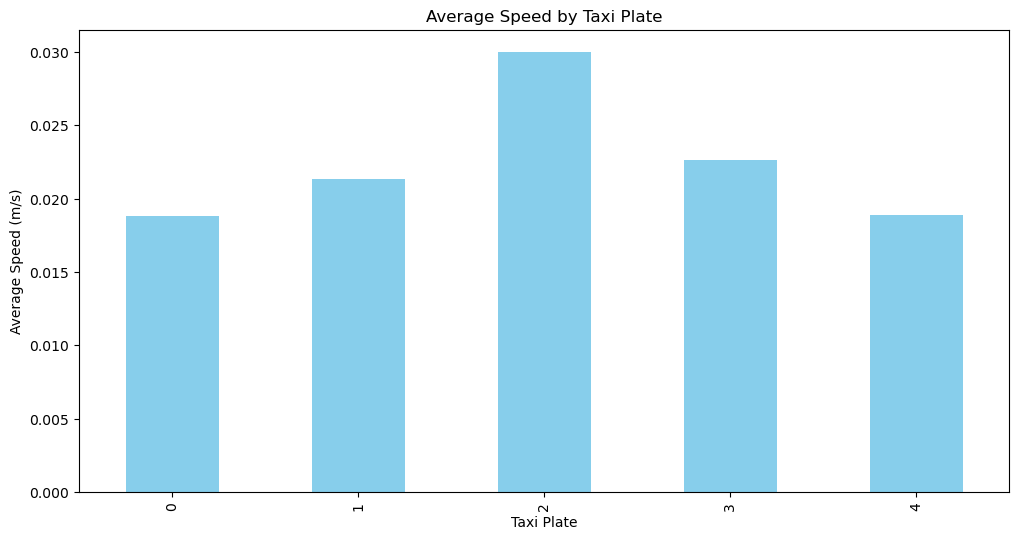

In [45]:
import matplotlib.pyplot as plt
# Visualize speed grouped by plate
plt.figure(figsize=(12, 6))
frame.groupby('plate')['speed'].mean().plot(kind='bar', color='skyblue')
plt.title('Average Speed by Taxi Plate')
plt.xlabel('Taxi Plate')
plt.ylabel('Average Speed (m/s)')
plt.show()

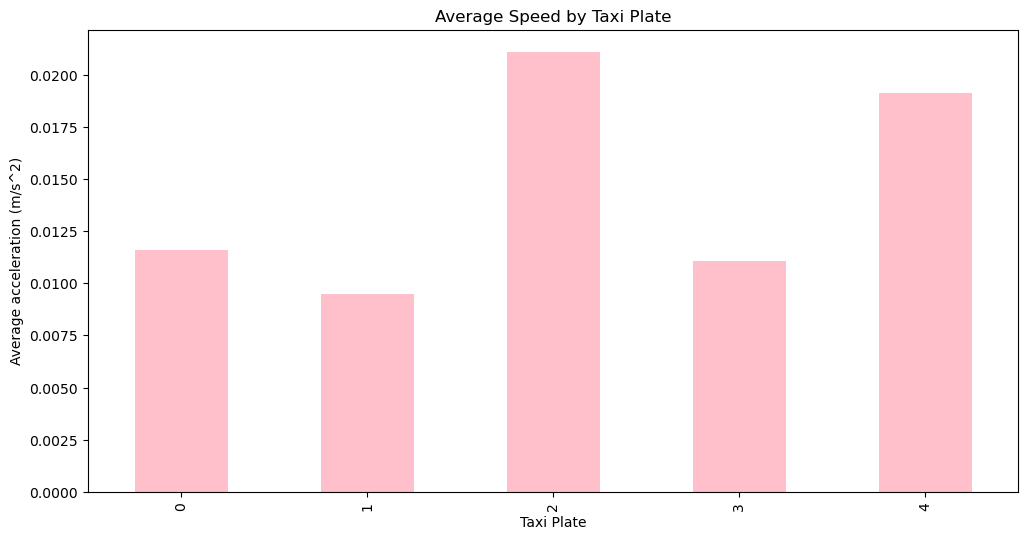

In [58]:
plt.figure(figsize=(12, 6))
frame.groupby('plate')['acceleration'].mean().plot(kind='bar', color='red')
plt.title('Average Speed by Taxi Plate')
plt.xlabel('Taxi Plate')
plt.ylabel('Average acceleration (m/s^2)')
plt.show()

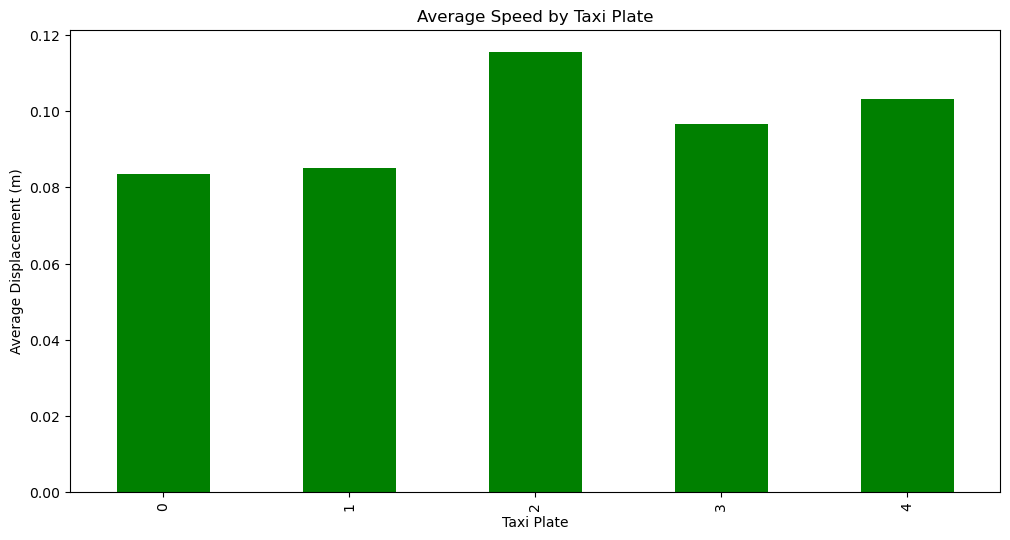

In [52]:
plt.figure(figsize=(12, 6))
frame.groupby('plate')['displacement'].mean().plot(kind='bar', color='green')
plt.title('Average Speed by Taxi Plate')
plt.xlabel('Taxi Plate')
plt.ylabel('Average Displacement (m)')
plt.show()